The function IV() is written according to the LUA script (VoltageOnCurrent.dat).  
The function IV_new() is modified based on IV() by considering the Knudsen Diffusion: 
    if Fkn = False, it is the exactly same as IV()
    if Fkn = True, it considers the Knudsen Diffusion's influence

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

def IV(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0
    th_e=           10.0
    th_c=           30.0
    th_ic=          500.0
    por_a=          40.0
    por_c=          40.0
    tort_a=         2.5
    tort_c=         2.5
    BV_alpha=       0.43236
    BV_prexp=       5639.0
    BV_Eact=        79616.0
    R_cont=         0.0
    BV_alpha2a=     0.44
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
    V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
      i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
      BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/i0)+math.sqrt((J/2.0/i0)**2+1))
    else:
    #  -- New method
      ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
      ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
      eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
      eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
      BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
      pCOc=1e-16
    else:
      pCOc=pCO
    
    if pCO2<=0 :
      pCO2c=1e-16
    else:
      pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0
    H2Oii=18.0
    COii=28.0
    CO2ii=44.0
    N2ii=28.0
    O2ii=32.0
    CH4ii=16.0
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
    DsurfH2th1=0.1
    DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #--
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
      Jcalc=J
    else:
      Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
    print('stabcheck: ', stabcheck)
    print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
      if stabcheck2>0 :
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        holdA2=0
        holdB2=0
        holdC2=0
        goober=1
      else:
        DeffH2=0.01*H2_UD*por_a/tort_a
        DeffH2O=0.01*H2O_UD*por_a/tort_a
        DeffCO=0.01*CO_UD*por_a/tort_a
        DeffCO2=0.01*CO2_UD*por_a/tort_a
        alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
        blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
        clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
        dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
        OPa_A=(Jcalc+blim+dlim)/blim/dlim
        OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
        OPa_C=(Jcalc-alim-clim)/alim/clim
        holdA2=OPa_A
        holdB2=OPa_B
        holdC2=OPa_C
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

def IV_new(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, Fkn=False,
           de_a=100**(-6),ne_a=0.5,alpha_a=1,de_c=100**(-6),ne_c=0.5,alpha_c=1):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0
    th_e=           10.0
    th_c=           30.0
    th_ic=          500.0
    por_a=          40.0
    por_c=          40.0
    tort_a=         2.5
    tort_c=         2.5
    BV_alpha=       0.43236
    BV_prexp=       5639.0
    BV_Eact=        79616.0
    R_cont=         0.0
    BV_alpha2a=     0.44
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
    V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
      i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
      BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/i0)+math.sqrt((J/2.0/i0)**2+1))
    else:
    #  -- New method
      ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
      ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
      eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
      eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
      BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
      pCOc=1e-16
    else:
      pCOc=pCO
    
    if pCO2<=0 :
      pCO2c=1e-16
    else:
      pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0 #unit [g/mol]
    H2Oii=18.0 #unit [g/mol]
    COii=28.0 #unit [g/mol]
    CO2ii=44.0 #unit [g/mol]
    N2ii=28.0 #unit [g/mol]
    O2ii=32.0 #unit [g/mol]
    CH4ii=16.0 #unit [g/mol]
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
    DsurfH2th1=0.1
    DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
        #-- Compute the effective Knudsen diffusion coefficient
        A0_a=6/de_a*(ne_a+(1-ne_a)*alpha_a**2)/(ne_a+(1-ne_a)*alpha_a**3)
        d0_a=4/A0_a*(0.01*por_a)/(1-0.01*por_a)
#         print('specific surface area: ', A0_a)
#         print('pore diameter: ', d0_a)
        DeffH2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2ii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffH2O_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2Oii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(COii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(CO2ii*10**(-3)))*por_a/tort_a*0.01*10**4

        A0_c=6/de_c*(ne_c+(1-ne_c)*alpha_c**2)/(ne_c+(1-ne_c)*alpha_c**3)
        d0_c=4/A0_c*(0.01*por_c)/(1-0.01*por_c)
        DeffO2_K=1/3*d0_c*math.sqrt(8*R*Tk/math.pi/(O2ii*10**(-3)))*por_c/tort_c*0.01*10**4
    #---------------------------------------------------------------------------------------------------------------------
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Cathode: O2 ',Deffc, 'vs.', DeffO2_K, '[cm2/s]')
        Deffc=(Deffc*DeffO2_K)/(Deffc+DeffO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Anode: H2 Dffe_normal ',DeffH2, 'vs. Deff_Knu', DeffH2_K, '[cm2/s]')
#         print('Anode: H2O Dffe_normal ',DeffH2O, 'vs. Deff_Knu', DeffH2O_K, '[cm2/s]')
#         print('Anode: CO Dffe_normal ',DeffCO, 'vs. Deff_Knu', DeffCO_K, '[cm2/s]')
#         print('Anode: CO2 Dffe_normal ',DeffCO2, 'vs. Deff_Knu', DeffCO2_K, '[cm2/s]')

        DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
        DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
        DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
        DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
      Jcalc=J
    else:
      Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('alim: ', alim)
#     print('blim: ', blim)
#     print('clim: ', clim)
#     print('dlim: ', dlim)
#     print('OPa_A: ', OPa_A)
#     print('OPa_B: ', OPa_B)
#     print('OPa_C: ', OPa_C)
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
      if stabcheck2>0 :
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        holdA2=0
        holdB2=0
        holdC2=0
        goober=1
#         print('DeffH2: ', DeffH2)
      else:
        DeffH2=0.01*H2_UD*por_a/tort_a
        DeffH2O=0.01*H2O_UD*por_a/tort_a
        DeffCO=0.01*CO_UD*por_a/tort_a
        DeffCO2=0.01*CO2_UD*por_a/tort_a
        #---------------------------------------------------------------------------------------------------------------------
        if Fkn==True:
            DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
            DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
            DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
            DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
        #---------------------------------------------------------------------------------------------------------------------
#         print('DeffH2: ', DeffH2)
        alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
        blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
        clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
        dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
        OPa_A=(Jcalc+blim+dlim)/blim/dlim
        OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
        OPa_C=(Jcalc-alim-clim)/alim/clim
        holdA2=OPa_A
        holdB2=OPa_B
        holdC2=OPa_C
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

The following cell provides typical fuel cell input parameters:

In [3]:
oT =900.0                       #Temperature oxidant (K)
fT =900.0                        #Temperature fuel (K)
pO2air=0.3                    # Air side partial pressure O2 (atm)
pN2air =0.7                    #Air side partial pressure N2 (atm)
pH2 = 0.4375                      #Fuel side partial pressure H2 (atm)
pH2O =0.3125                      #Fuel side partial pressure H2O (atm)
pCO=0.0625                       # Fuel side partial pressure CO (atm)
pCO2=0.0625                      # Fuel side partial pressure CO2 (atm)
pCH4=0.125                      # Fuel side partial pressure CH4 (atm)
pN2=0.0                       # Fuel side partial pressure N2 (atm)
pSys=1.0                      #System pressure (atm)

The following cell provides typical fuel cell properties (baseline values):

In [ ]:
de_a=0.5*10**(-6)             #diameter of electrically conducting particles
ne_a=0.2                      #number fraction of electrically conducting particles
alpha_a=0.4                   #the particle size ratio of ionic to electronic conducting particles
de_c=0.5*10**(-6)
ne_c=0.2
alpha_c=0.4

The following cell studies the sensitivity of voltage output to the diameter of electrically conducting particles in Anode:

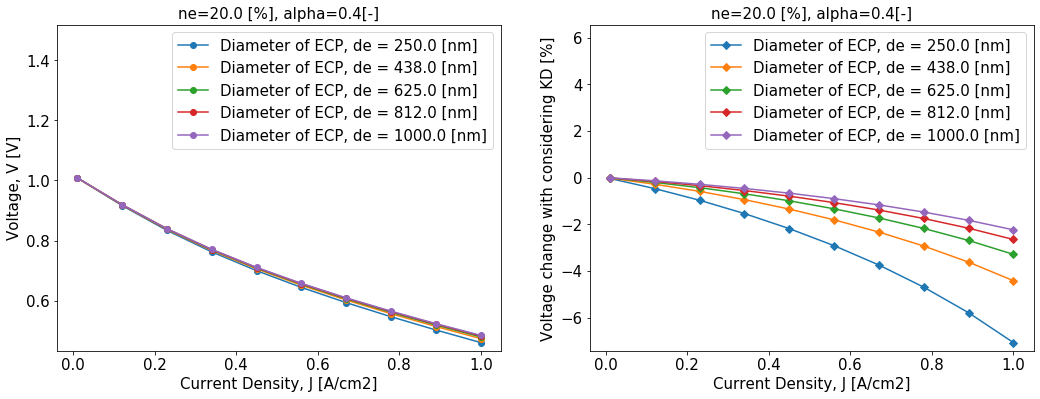

In [7]:
#voltage considering Knudsen Diffusion (cathode refering to baseline): de sensitivity
V_WKn=np.zeros([5, 10])
V_diff=np.zeros([5, 10])
delist=np.linspace(0.25, 1, num=5)*10**(-6)    #NI/YSZ(79%/21%) SOFC, unit [m]
Jlist=np.linspace(0.01, 1, num=10)             #Current density, unit [A/cm2]

for j in range(10):
    for i in range(5):
        V_NKn, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys)
#         print('without Knudsen diffusion: ', V_NKn)
        V, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                True,delist[i],ne_a,alpha_a, de_c,ne_c,alpha_c)
        V_WKn[i, j]=V
        V_diff[i, j]=(V-V_NKn)/V_NKn

X=Jlist
xname = 'Current Density, J [A/cm2]'
yname1 = 'Voltage, V [V]'
yname2 = 'Voltage change with considering KD [%]'

plt.figure(figsize=(17.5,6))
plt.subplot(1, 2, 1)
for j in range(5):
    Y=V_WKn[j, :]
    plt.plot(X, Y, '-o', label='Diameter of ECP, de = '+str(np.round(delist[j]*10**9))+' [nm]')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.8)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname1, fontsize = 15)
plt.title('ne='+str(ne_a*100)+' [%], alpha='+str(alpha_a)+'[-]', fontsize = 15)

plt.subplot(1, 2, 2)
for j in range(5):
    Y=V_diff[j, :]*100
    plt.plot(X, Y, '-D', label='Diameter of ECP, de = '+str(np.round(delist[j]*10**9))+' [nm]')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.8)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname2, fontsize = 15)
plt.title('ne='+str(ne_a*100)+' [%], alpha='+str(alpha_a)+'[-]', fontsize = 15)
plt.show()

The following cell studies the sensitivity of voltage output to the number fraction of electrically conducting particles in Anode:

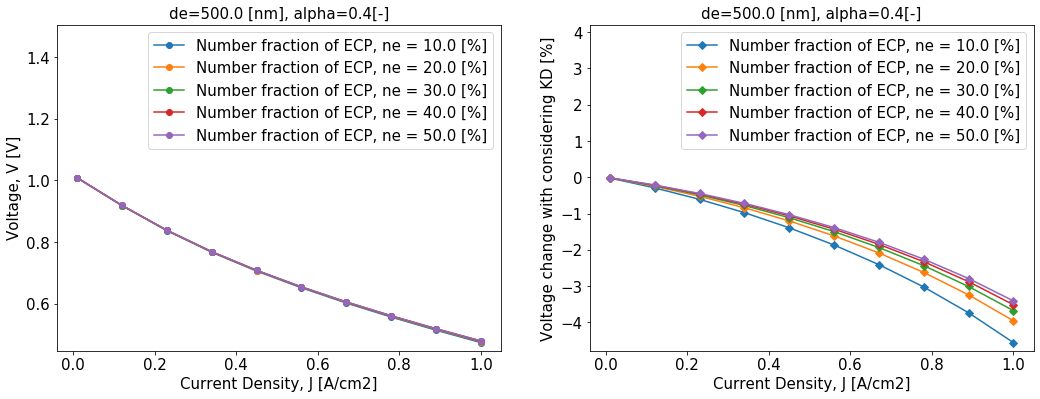

In [8]:
#voltage without considering Knudsen Diffusion (cathode refering to baseline): ne sensitivity
V_WKn=np.zeros([5, 10])
V_diff=np.zeros([5, 10])
nelist=np.linspace(0.1, 0.5, num=5)    #NI/YSZ(79%/21%) SOFC: ne [0.09~0.36]
Jlist=np.linspace(0.01, 1, num=10)             #Current density, unit [A/cm2]

for j in range(10):
    for i in range(5):
        V_NKn, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys)
        V, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                True,de_a,nelist[i],alpha_a, de_c,ne_c,alpha_c)
        V_WKn[i, j]=V
        V_diff[i, j]=(V-V_NKn)/V_NKn

X=Jlist
xname = 'Current Density, J [A/cm2]'
yname1 = 'Voltage, V [V]'
yname2 = 'Voltage change with considering KD [%]'

plt.figure(figsize=(17.5,6))
plt.subplot(1, 2, 1)
for j in range(5):
    Y=V_WKn[j, :]
    plt.plot(X, Y, '-o', label='Number fraction of ECP, ne = '+str(np.round(nelist[j]*100))+' [%]')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.8)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname1, fontsize = 15)
plt.title('de='+str(de_a*10**9)+' [nm], alpha='+str(alpha_a)+'[-]', fontsize = 15)

plt.subplot(1, 2, 2)
for j in range(5):
    Y=V_diff[j, :]*100
    plt.plot(X, Y, '-D', label='Number fraction of ECP, ne = '+str(np.round(nelist[j]*100))+' [%]')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.8)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname2, fontsize = 15)
plt.title('de='+str(de_a*10**9)+' [nm], alpha='+str(alpha_a)+'[-]', fontsize = 15)
plt.show()

The following cell studies the sensitivity of voltage output to the particle size ratio of ionic to electronic conducting particles in Anode:

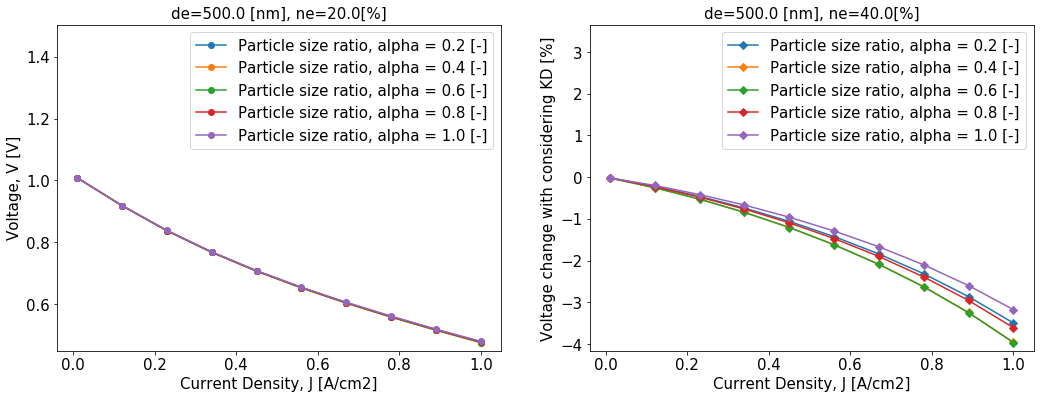

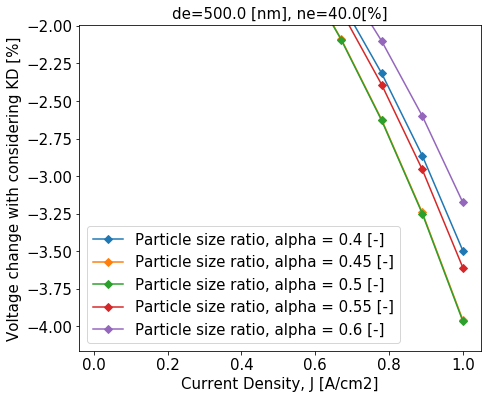

In [9]:
#voltage without considering Knudsen Diffusion (cathode refering to baseline): alpha sensitivity
V_WKn=np.zeros([5, 10])
V_diff=np.zeros([5, 10])
alphalist=np.linspace(0.2, 1, num=5)    #NI/YSZ(79%/21%) SOFC: alpha [0.13~0.53]
Jlist=np.linspace(0.01, 1, num=10)             #Current density, unit [A/cm2]

for j in range(10):
    for i in range(5):
        V_NKn, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys)
        V, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                True,de_a,ne_a,alphalist[i], de_c,ne_c,alpha_c)
        V_WKn[i, j]=V
        V_diff[i, j]=(V-V_NKn)/V_NKn

X=Jlist
xname = 'Current Density, J [A/cm2]'
yname1 = 'Voltage, V [V]'
yname2 = 'Voltage change with considering KD [%]'

plt.figure(figsize=(17.5,6))
plt.subplot(1, 2, 1)
for j in range(5):
    Y=V_WKn[j, :]
    plt.plot(X, Y, '-o', label='Particle size ratio, alpha = '+str(np.round(alphalist[j]*100)/100)+' [-]')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.8)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname1, fontsize = 15)
plt.title('de='+str(de_a*10**9)+' [nm], ne='+str(ne_a*100)+'[%]', fontsize = 15)

plt.subplot(1, 2, 2)
for j in range(5):
    Y=V_diff[j, :]*100
    plt.plot(X, Y, '-D', label='Particle size ratio, alpha = '+str(np.round(alphalist[j]*100)/100)+' [-]')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.8)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname2, fontsize = 15)
plt.title('de='+str(de_a*10**9)+' [nm], ne='+str(alpha_a*100)+'[%]', fontsize = 15)
plt.show()

#
alphalist=np.linspace(0.4, 0.6, num=5)    #NI/YSZ(79%/21%) SOFC: alpha [0.13~0.53]

for j in range(5):
    for i in range(5):
        V_NKn, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys)
        V, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                True,de_a,ne_a,alphalist[i], de_c,ne_c,alpha_c)
        V_WKn[i, j]=V
        V_diff[i, j]=(V-V_NKn)/V_NKn

plt.figure(figsize=(7.2,6))
for j in range(5):
    Y=V_diff[j, :]*100
    plt.plot(X, Y, '-D', label='Particle size ratio, alpha = '+str(np.round(alphalist[j]*100)/100)+' [-]')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymin+(ymax-ymin)*0.5)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname2, fontsize = 15)
plt.title('de='+str(de_a*10**9)+' [nm], ne='+str(alpha_a*100)+'[%]', fontsize = 15)
plt.show()

The following two cells study the potential maximum voltage decrease at extreme cases:

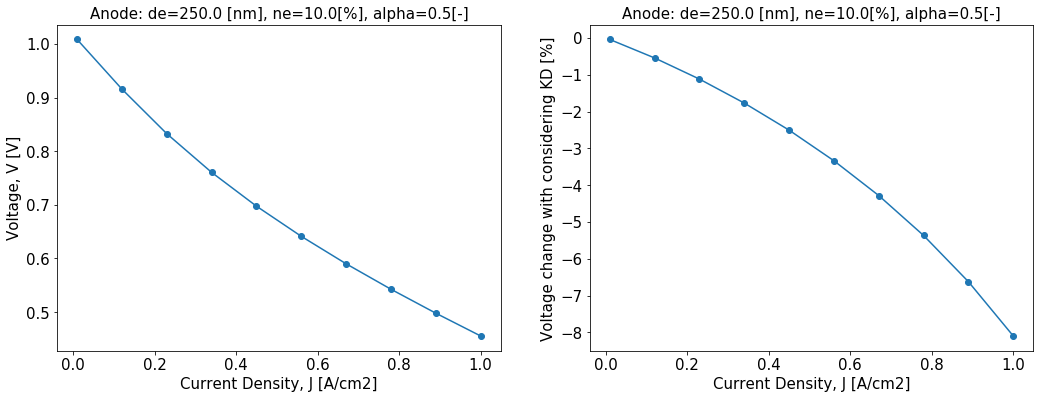

In [10]:
#voltage considering Knudsen Diffusion (Anode extreme case)

#Baselines for Knudsen Diffusion
# de_a=0.27198*10**(-6)           #diameter of electrically conducting particles
de_a=0.25*10**(-6)           #diameter of electrically conducting particles
ne_a=0.1                 #number fraction of electrically conducting particles
alpha_a=0.5                 #the particle size ratio of ionic to electronic conducting particles

V_WKn=np.zeros(10)
V_diff=np.zeros(10)
Jlist=np.linspace(0.01, 1, num=10)             #Current density, unit [A/cm2]

for j in range(10):
    V_NKn, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys)
    V, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                            True,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
    V_WKn[j]=V
    V_diff[j]=(V-V_NKn)/V_NKn

X=Jlist
xname = 'Current Density, J [A/cm2]'
yname1 = 'Voltage, V [V]'
yname2 = 'Voltage change with considering KD [%]'

plt.figure(figsize=(17.5,6))
plt.subplot(1, 2, 1)
plt.plot(X, V_WKn, '-o')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname1, fontsize = 15)
plt.title('Anode: de='+str(de_a*10**9)+' [nm], ne='+str(ne_a*100)+'[%], alpha='+str(alpha_a)+'[-]', fontsize = 15)

plt.subplot(1, 2, 2)
plt.plot(X, V_diff*100, '-o')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname2, fontsize = 15)
plt.title('Anode: de='+str(de_a*10**9)+' [nm], ne='+str(ne_a*100)+'[%], alpha='+str(alpha_a)+'[-]', fontsize = 15)
plt.show()

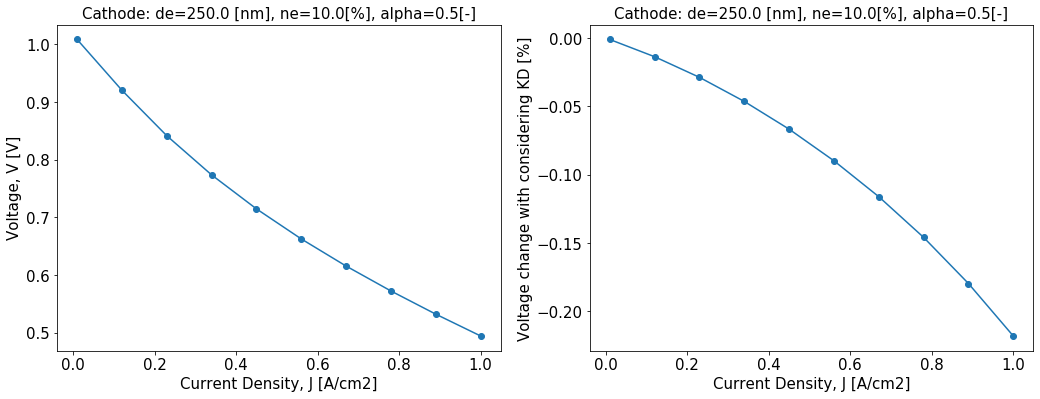

In [11]:
#voltage considering Knudsen Diffusion (only cathode, extreme case)

#Baselines for Knudsen Diffusion
de_a=1                        #diameter of electrically conducting particles
ne_a=0.5                      #number fraction of electrically conducting particles
alpha_a=1                   #the particle size ratio of ionic to electronic conducting particles

de_c=0.25*10**(-6)
ne_c=0.1
alpha_c=0.5

V_WKn=np.zeros(10)
V_diff=np.zeros(10)
Jlist=np.linspace(0.01, 1, num=10)             #Current density, unit [A/cm2]

for j in range(10):
    V_NKn, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys)
    V, Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                            True,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
    V_WKn[j]=V
    V_diff[j]=(V-V_NKn)/V_NKn

X=Jlist
xname = 'Current Density, J [A/cm2]'
yname1 = 'Voltage, V [V]'
yname2 = 'Voltage change with considering KD [%]'

plt.figure(figsize=(17.5,6))
plt.subplot(1, 2, 1)
plt.plot(X, V_WKn, '-o')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname1, fontsize = 15)
plt.title('Cathode: de='+str(de_c*10**9)+' [nm], ne='+str(ne_c*100)+'[%], alpha='+str(alpha_c)+'[-]', fontsize = 15)

plt.subplot(1, 2, 2)
plt.plot(X, V_diff*100, '-o')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname2, fontsize = 15)
plt.title('Cathode: de='+str(de_c*10**9)+' [nm], ne='+str(ne_c*100)+'[%], alpha='+str(alpha_c)+'[-]', fontsize = 15)
plt.show()